In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/solar.csv', usecols=['Data','Time','Radiation','Temperature'])
solar_date = df.Data.str.extract('([/|\w]+\s).+')[0]
df['Data'] = pd.to_datetime(solar_date + df.Time)
df = df.drop(columns='Time').rename(columns={'Data':'Datetime'}).set_index('Datetime').sort_index()
df.head(3)

,Radiation,Temperature
Datetime,,
2016-09-01 00:00:08,2.58,51
2016-09-01 00:05:10,2.83,51
2016-09-01 00:20:06,2.16,51


#### 2.
(a)

In [3]:
s = df.index.to_series().reset_index(drop=True).diff().dt.total_seconds()
max_3 = s.nlargest(3).index
df.index[max_3.union(max_3-1)]

DatetimeIndex(['2016-09-29 23:55:26', '2016-10-01 00:00:19',
               '2016-11-29 19:05:02', '2016-12-01 00:00:02',
               '2016-12-05 20:45:53', '2016-12-08 11:10:42'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

(b)

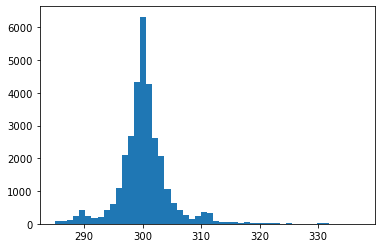

In [4]:
res = s.mask((s>s.quantile(0.99))|(s<s.quantile(0.01)))
_ = plt.hist(res, bins=50)

#### 3.
(a)

In [5]:
res = df.Radiation.rolling('6H').corr(df.Temperature)
res.tail(3)

Datetime
2016-12-31 23:45:04    0.328574
2016-12-31 23:50:03    0.261883
2016-12-31 23:55:01    0.262406
dtype: float64

(b)

In [6]:
res = df.Temperature.resample('6H', origin='03:00:00').mean()
res.head(3)

Datetime
2016-08-31 21:00:00    51.218750
2016-09-01 03:00:00    50.033333
2016-09-01 09:00:00    59.379310
Freq: 6H, Name: Temperature, dtype: float64

(c)

In [85]:
my_dt = df.index.shift(freq='-6H')
int_loc = [df.index.get_loc(i, method='nearest') for i in my_dt]
res = df.Radiation.iloc[int_loc]
res.tail(3)

Datetime
2016-12-31 17:45:02    9.33
2016-12-31 17:50:01    8.49
2016-12-31 17:55:02    5.84
Name: Radiation, dtype: float64

### Ex2：水果销量数据集
#### 1.
(a)

In [86]:
df = pd.read_csv('./data/fruit.csv')
df.Date = pd.to_datetime(df.Date)
df_grape = df.query("Fruit == 'Grape'")
res = df_grape.groupby([np.where(df_grape.Date.dt.day<=15,'First', 'Second'),
                        df_grape.Date.dt.month])['Sale'].mean().to_frame().unstack(0).droplevel(0,axis=1)
res = (res.First/res.Second).rename_axis('Month')
res.head()

Month
1    1.174998
2    0.968890
3    0.951351
4    1.020797
5    0.931061
dtype: float64

(b)

In [87]:
df[df.Date.dt.is_month_end].query("Fruit == 'Pear'").groupby('Date').Sale.sum().head()

Date
2019-01-31    847
2019-02-28    774
2019-03-31    761
2019-04-30    648
2019-05-31    616
Name: Sale, dtype: int64

(c)

In [88]:
df[df.Date.isin(pd.date_range('20190101', '20191231',freq='BM'))].query("Fruit == 'Pear'").groupby('Date').Sale.mean().head()

Date
2019-01-31    60.500000
2019-02-28    59.538462
2019-03-29    56.666667
2019-04-30    64.800000
2019-05-31    61.600000
Name: Sale, dtype: float64

(d)

In [89]:
target_dt = df.drop_duplicates().groupby(df.Date.drop_duplicates().dt.month)['Date'].nlargest(5).reset_index(drop=True)
res = df.set_index('Date').loc[target_dt].reset_index().query("Fruit == 'Apple'")
res = res.groupby(res.Date.dt.month)['Sale'].mean().rename_axis('Month')
res.head()

Month
1    65.313725
2    54.061538
3    59.325581
4    65.795455
5    57.465116
Name: Sale, dtype: float64

#### 2.

In [90]:
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
week_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sum']
group1 = df.Date.dt.month_name().astype('category').cat.reorder_categories(month_order, ordered=True)
group2 = df.Fruit
group3 = df.Date.dt.dayofweek.replace(dict(zip(range(7),week_order))).astype('category').cat.reorder_categories(week_order, ordered=True)
res = df.groupby([group1, group2,group3])['Sale'].count().to_frame().unstack(0).droplevel(0,axis=1)
res.head()

Date        January  February  March  April  May  June  July  August  \
Fruit Date                                                             
Apple Mon        46        43     43     47   43    40    41      38   
      Tue        50        40     44     52   46    39    50      42   
      Wed        50        47     37     43   39    39    58      43   
      Thu        45        35     31     47   58    33    52      44   
      Fri        32        33     52     31   46    38    37      48   

Date        September  October  November  December  
Fruit Date                                          
Apple Mon          59       42        39        45  
      Tue          40       57        47        47  
      Wed          35       46        47        38  
      Thu          36       63        37        40  
      Fri          34       37        46        41

#### 3.

In [91]:
df_apple = df[(df.Fruit=='Apple')&(~df.Date.dt.dayofweek.isin([5,6]))]
s = pd.Series(df_apple.Sale.values,index=df_apple.Date).groupby('Date').sum()
res = s.rolling('10D').mean().reindex(pd.date_range('20190101','20191231')).fillna(method='ffill')
res.head()

2019-01-01    189.000000
2019-01-02    335.500000
2019-01-03    520.333333
2019-01-04    527.750000
2019-01-05    527.750000
Freq: D, dtype: float64